**PUPRPOSE OF THE PROJECT**

We submit that we own capital in three currencies. The following possible transactions: PLN->EUR, PLN->UDS, EUR->PLN, USD->PLN. The goal is to predicate the direction of investment.



---
**INPUTS**

In [1]:
# the money you have
PLN = 40000
EUR = 10000
USD = 5000

# investment time
days = 30

---
**DATA COLLECTION AND VISUALIZATION**

In [2]:
# !pip install pandas-datareader

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA

import warnings

In [4]:
# reading data from the webside

url1 = "https://stooq.pl/q/d/l/?s=eurpln&i=d"
df_EUR_PLN = pd.read_csv(url1, delimiter=",", index_col=0, parse_dates=True)

print(df_EUR_PLN.tail())

url2 = "https://stooq.pl/q/d/l/?s=usdpln&i=d"
df_USD_PLN = pd.read_csv(url2, delimiter=",", index_col=0, parse_dates=True)

print(df_USD_PLN.tail())

            Otwarcie  Najwyzszy  Najnizszy  Zamkniecie
Data                                                  
2023-04-11   4.68733    4.69253    4.66547     4.66718
2023-04-12   4.66706    4.67480    4.65041     4.65322
2023-04-13   4.65156    4.65561    4.63092     4.63867
2023-04-14   4.63918    4.65848    4.63333     4.64432
2023-04-17   4.64272    4.64507    4.62568     4.62929
            Otwarcie  Najwyzszy  Najnizszy  Zamkniecie
Data                                                  
2023-04-11   4.31535    4.31615    4.27020     4.27715
2023-04-12   4.27700    4.27990    4.22876     4.23328
2023-04-13   4.23165    4.23705    4.19015     4.19926
2023-04-14   4.19976    4.23051    4.18425     4.22338
2023-04-17   4.22222    4.23674    4.21255     4.21763


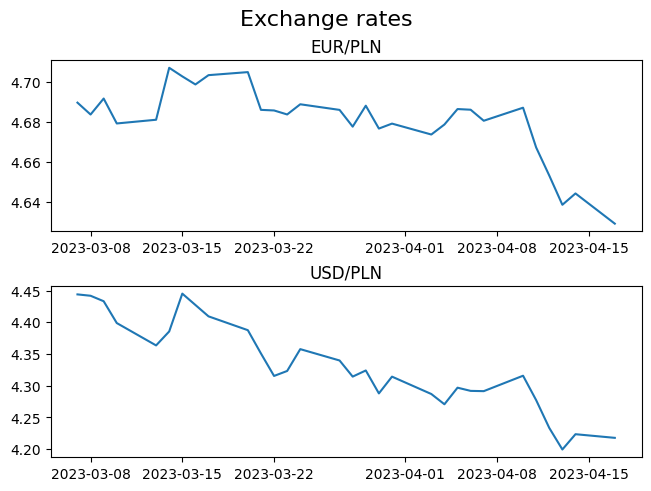

In [5]:
# visualization

previous_days = days*1 # training/test days

df_EUR_PLN_part = df_EUR_PLN["Zamkniecie"][-previous_days:]
df_USD_PLN_part = df_USD_PLN["Zamkniecie"][-previous_days:]

fig, axs = plt.subplots(2, 1, constrained_layout=True)
axs[0].plot(df_EUR_PLN_part)
axs[0].set_title('EUR/PLN')
fig.suptitle('Exchange rates', fontsize=16)

axs[1].plot(df_USD_PLN_part)
axs[1].set_title('USD/PLN')

plt.show()

---
**LINEAR REGRESSION**





In [6]:
# function for linear regression

def LinReg(name, df_part, previous_days, days):

  X = pd.DataFrame(pd.Series(np.arange(1, len(df_part) + 1), name='day')) # days
  y = df_part.values # closing prices
  X_pred_future = pd.DataFrame(pd.Series(np.arange(
      previous_days + 1, previous_days + days + 1), name='day')) # days to predict

  # Division of data into training and test collection
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=0)

  regression = LinearRegression()

  # Training the model
  regression.fit(X_train, y_train)

  # Prediction on test data
  y_pred_test = regression.predict(X_test)

  mse = mean_squared_error(y_test, y_pred_test)
  print(f'MSE: {mse}')

  # Prediction for the future  
  y_pred_future = regression.predict(X_pred_future)


  plt.scatter(X_test, y_test, color='blue', label='Real values')
  plt.scatter(X_train, y_train, color='blue')
  plt.plot(X_test, y_pred_test, color='green', label='Prediction')
  plt.plot(X_pred_future, y_pred_future, color='red', label='Prediction - future')
  plt.xlabel('Days')
  plt.title(f'{name}/PLN - LR')
  plt.legend()
  plt.show()


MSE: 0.00014923576186334843


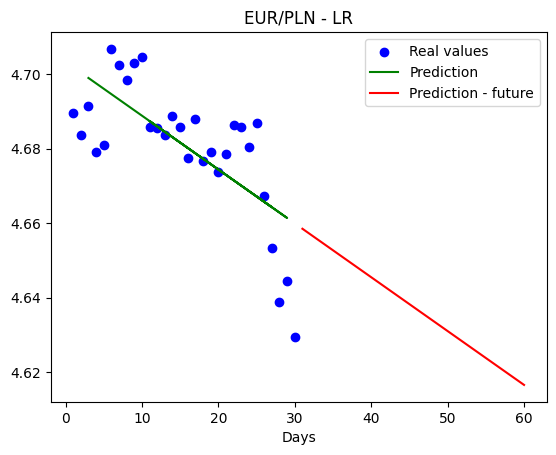

In [7]:
previous_days = days*1 # training/test days

LinReg("EUR", df_EUR_PLN_part, previous_days, days)

MSE: 0.0006527996017687827


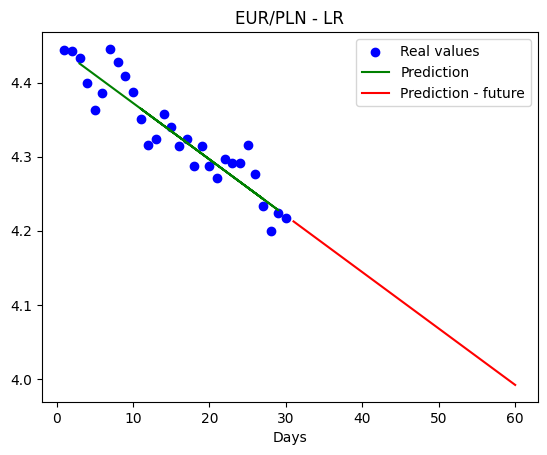

In [8]:
LinReg("EUR", df_USD_PLN_part, previous_days, days)

---
**ARIMA**

In [9]:
warnings.filterwarnings('ignore')

In [10]:
# function to select parameters

def ARIMA_param(df, previous_days, days):

  df_Arima = df["Zamkniecie"][-previous_days:]
  data = pd.DataFrame(df_Arima.values)

  test_days = days
  train_data = data.iloc[:len(data)-test_days] # first days as a training set
  test_data = data.iloc[len(data)-test_days:] # last days as a test collection

  mse_min = np.Infinity

  for i in range(0,4):
    for j in range(0,4):
      for k in range(0,4):

          # ARIMA model
          model = ARIMA(train_data, order=(i, j, k))
          model_fit = model.fit()

          # Forecasting on a test set
          forecast = model_fit.forecast(steps = test_days)
          mse = mean_squared_error(forecast, test_data)

          if mse_min > mse: # search for the minimum
            mse_min = mse
            i_min, j_min, k_min = i, j, k

  print(f'p: {i_min}   d: {j_min}   q: {k_min}    MSE: {mse_min}')

  return i_min, j_min, k_min

In [11]:
def ARIMA_forecast(name, train_data_all, days, p_min, d_min, q_min):
  
  # ARIMA model
  model = ARIMA(train_data_all, order=(p_min, d_min, q_min)) # p=0, d=3, q=3
  model_fit = model.fit()

  # Prediction
  forecast = model_fit.forecast(steps = days)

  plt.figure(figsize=(10, 5))
  plt.plot(train_data_all, label='Traning data')
  plt.plot(np.arange(len(train_data_all), len(train_data_all)+ days), forecast, label='Prediction')
  plt.xlabel('Days')
  plt.title(f'{name}/PLN - ARIMA')
  plt.legend()
  plt.show()

  return float(forecast[-1:].values)

In [12]:
# EUR/PLN - ARIMA

previous_days = days*11 # - training and test days

p_min, d_min, q_min = ARIMA_param(df_EUR_PLN, previous_days, days)

p: 2   d: 2   q: 0    MSE: 0.00017670788447800975


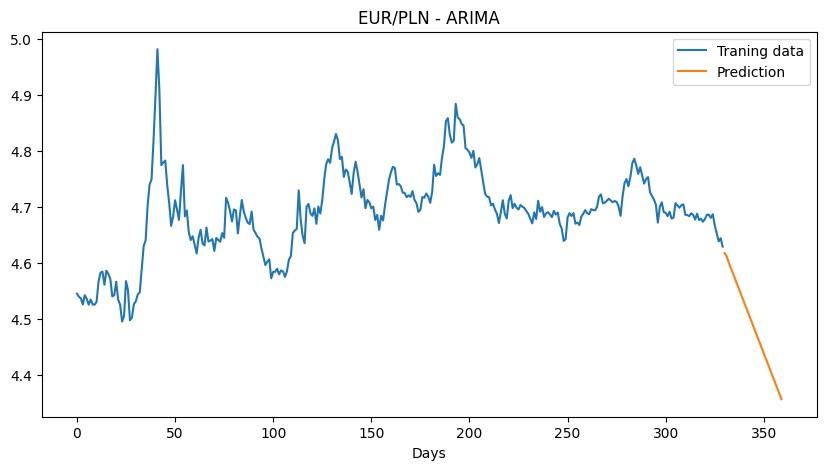

In [13]:
train_data_all = pd.DataFrame(df_EUR_PLN["Zamkniecie"][-previous_days:].values)

start_EUR = float(train_data_all[-1:].values)
end_EUR = ARIMA_forecast("EUR", train_data_all, days, p_min, d_min, q_min)

In [14]:
# USD/PLN - ARIMA

previous_days = days*11 # - training and test days

p_min, d_min, q_min = ARIMA_param(df_USD_PLN, previous_days, days)

p: 1   d: 3   q: 3    MSE: 0.0012827059054468229


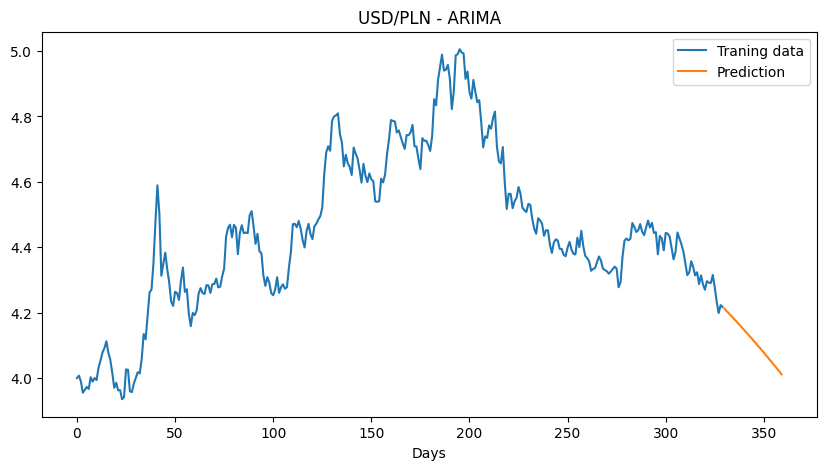

In [15]:
train_data_all = pd.DataFrame(df_USD_PLN["Zamkniecie"][-previous_days:].values)

start_USD = float(train_data_all[-1:].values)
end_USD = ARIMA_forecast("USD", train_data_all, days, p_min, d_min, q_min)

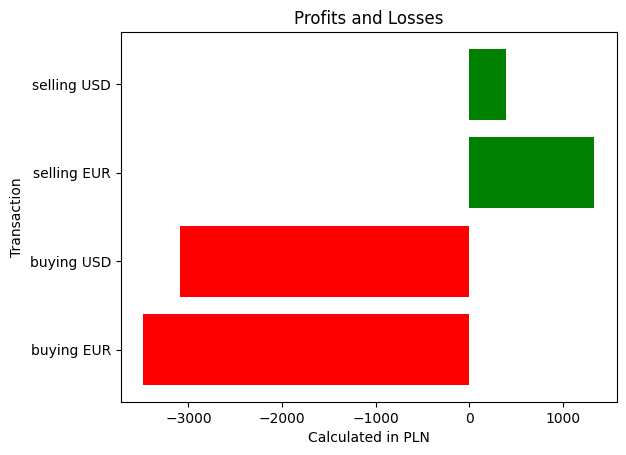

In [17]:
if PLN != 0:
  profit_buying_EUR = ((PLN/start_EUR)*end_EUR)*0.97 - PLN
  profit_buying_USD = ((PLN/start_USD)*end_USD)*0.97 - PLN

if EUR != 0:
  profit_selling_EUR = ((EUR*start_EUR*0.97)/end_EUR - EUR)*end_EUR

if USD != 0:
  profit_selling_USD = ((USD*start_USD*0.97)/end_USD - USD)*end_USD


numbers = [profit_buying_EUR, profit_buying_USD, profit_selling_EUR, profit_selling_USD]
labels = ["buying EUR", "buying USD", "selling EUR", "selling USD"]

fig, ax = plt.subplots()
ax.set_title('Profits and Losses')
ax.set_xlabel('Calculated in PLN')
ax.set_ylabel('Transaction')
for i in range(len(numbers)):
    if numbers[i] >= 0:
        ax.barh(labels[i], numbers[i], color='green')
    else:
        ax.barh(labels[i], numbers[i], color='red')

plt.show()
